In [2]:
%cd ..

/home/pauline/Dokumente/Delab_Projekt/delab


In [3]:
import pandas as pd

In [4]:
from util.sql_switch import get_query_native

#select all authors from the database

authors_tweets = get_query_native(
    "SELECT ta.id as author_id, conversation_id, screen_name , is_climate_author, climate_author_type FROM delab_tweet t, delab_tweetauthor ta WHERE t.author_id=ta.twitter_id")
#select only authors that are 'climate auhtors'
clauthors_tweets = authors_tweets.loc[authors_tweets['is_climate_author']== True]
clauthors_tweets = clauthors_tweets.replace(['non-governmental organisation'], 'NGO')

#group author by auhtor and conversations in order to analize the calculated variables for each author in each conversation
clauthors_tweets = clauthors_tweets.groupby(["author_id", "screen_name", "climate_author_type","conversation_id"]).mean()

#get needed variables from 'conversation' and 'conversation author metrics'
c_cam = get_query_native(
    "SELECT author_id, is_root_author, c.conversation_id, depth, branching_factor, centrality, baseline_vision, n_posts, root_dominance FROM delab_conversation c, delab_conversationauthormetrics cam WHERE c.conversation_id=cam.conversation_id")
c_cam = c_cam.groupby(["author_id", "conversation_id"]).mean()
c_cam = c_cam.loc[c_cam['is_root_author']==True]
#join both dataframes in order to match the climate author type with variables we want to analyze
analysis = clauthors_tweets.join(c_cam)
analysis_flattened = analysis.reset_index()
analysis_flattened

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance
0,1,1414150136607948808,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1427328275773280265,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1509780204948017154,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1521343957086740486,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,1532708095704580100,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0


In [5]:
import networkx as nx

In [6]:
#calculate the total amount of tweets in each conversation
tweet_ids = get_query_native(
                "SELECT conversation_id FROM delab_tweet")
tweet_ids
tweet_count = tweet_ids['conversation_id'].value_counts()
tweet_count = tweet_count.to_frame()
tweet_count = tweet_count.rename(columns={"conversation_id":"n_posts"})
tweet_count['conversation_id'] = tweet_count.index
tweet_count

using postgres


/home/pauline/Dokumente/Delab_Projekt/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,n_posts,conversation_id
1603181423787380737,190875,1603181423787380737
1608175680407191552,81226,1608175680407191552
1612973043583696897,77559,1612973043583696897
1607677190254235648,75456,1607677190254235648
1608188826291167242,43518,1608188826291167242
...,...,...
1217415150401212417,6,1217415150401212417
1402577374131195908,6,1402577374131195908
1101417285342973952,6,1101417285342973952
1498210508448710656,6,1498210508448710656


In [7]:
#add the total amount of tweets to the previous dataframe
mapped_columns = dict(zip(tweet_count.conversation_id, tweet_count.n_posts))
analysis_flattened["total_counts"] = analysis_flattened["conversation_id"].map(mapped_columns)
analysis_flattened

,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
0,1,1414150136607948808,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,794
1,1,1427328275773280265,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590
2,1,1509780204948017154,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,321
3,1,1521343957086740486,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
4,1,1532708095704580100,mnyomb1,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9137,1618,1610320983872634881,climate_ice,scientist,1.0,1.0,4.0,6.0,2.166667,0.285156,2.0,7.0,7
9138,1619,1519656711455313921,EricTopol,scientist,1.0,1.0,3.0,8.0,6.500000,0.500000,1.0,9.0,9
9139,1619,1530931490636255232,EricTopol,scientist,1.0,1.0,7.0,35.0,21.166667,0.250000,1.0,36.0,36
9140,1619,1593290345646694401,EricTopol,scientist,1.0,1.0,10.0,46.0,22.722222,0.500000,1.0,47.0,47


In [8]:
#count how many conversation for each climate author type were downloaded
most_count = analysis_flattened.groupby('climate_author_type').count()
most_count

,author_id,conversation_id,screen_name,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,,,,,,
NGO,1973,1973,1973,1973,1744,1744,1744,1744,1744,1744,1744,1973
activist,1336,1336,1336,1336,1066,1066,1066,1066,1066,1066,1066,1336
journalist,970,970,970,970,838,838,838,838,838,838,838,970
organisation,1332,1332,1332,1332,1301,1301,1301,1301,1301,1301,1301,1332
politician,1185,1185,1185,1185,1073,1073,1073,1073,1073,1073,1073,1185
scientist,2346,2346,2346,2346,1883,1883,1883,1883,1883,1883,1883,2346


## Analyse
- Nach climate_author_type analysieren
- Fragen:
    - in wievielen Konversationen sind die Autoren durchschnittlich vertreten?
    - welche Zentralität haben die AUtoren durchschnittlich?
    - welche root dominance haben die Autoren durchschnittlich?
    - welchen branching_factor und welche depth haben die Konversationen, in denen die Autoren root auhtor sind duchschnittlich?
    

In [9]:
#group the previous dataframe by climate author type to analyze by author type
climate_analysis = analysis_flattened.groupby(['climate_author_type']).mean()
climate_analysis = climate_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
climate_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,6.333716,96.807913,33.098114,0.383259,2.004014,97.696875,151.692347
activist,9.511257,211.167917,99.938173,0.361230,3.260788,212.080920,848.776198
journalist,7.571599,61.198091,17.453906,0.316467,3.278043,62.198091,126.280412
organisation,3.862414,31.230592,21.210071,0.456124,1.695619,32.169226,36.090841
politician,6.762349,153.401678,88.352143,0.392665,1.837838,154.401678,273.590717
scientist,8.860860,112.071163,40.939892,0.343446,3.231014,113.042101,240.592072


In [10]:
#same with median to compare to mean
median_analysis = analysis_flattened.groupby(['climate_author_type']).median()
median_analysis = median_analysis.drop(columns=['author_id', 'conversation_id', 'is_climate_author', 'is_root_author' ])
median_analysis

,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
climate_author_type,,,,,,,
NGO,4.0,14.0,7.666667,0.500000,1.0,15.0,17.0
activist,7.0,42.0,14.208333,0.500000,1.0,43.0,65.0
journalist,5.0,21.0,7.000000,0.285156,2.0,22.0,26.0
organisation,3.0,12.0,9.000000,0.500000,1.0,13.0,14.0
politician,5.0,22.0,10.866667,0.500000,1.0,23.0,26.0
scientist,6.0,31.0,10.403016,0.500000,1.0,32.0,39.0


In [11]:
import matplotlib.pyplot as plt

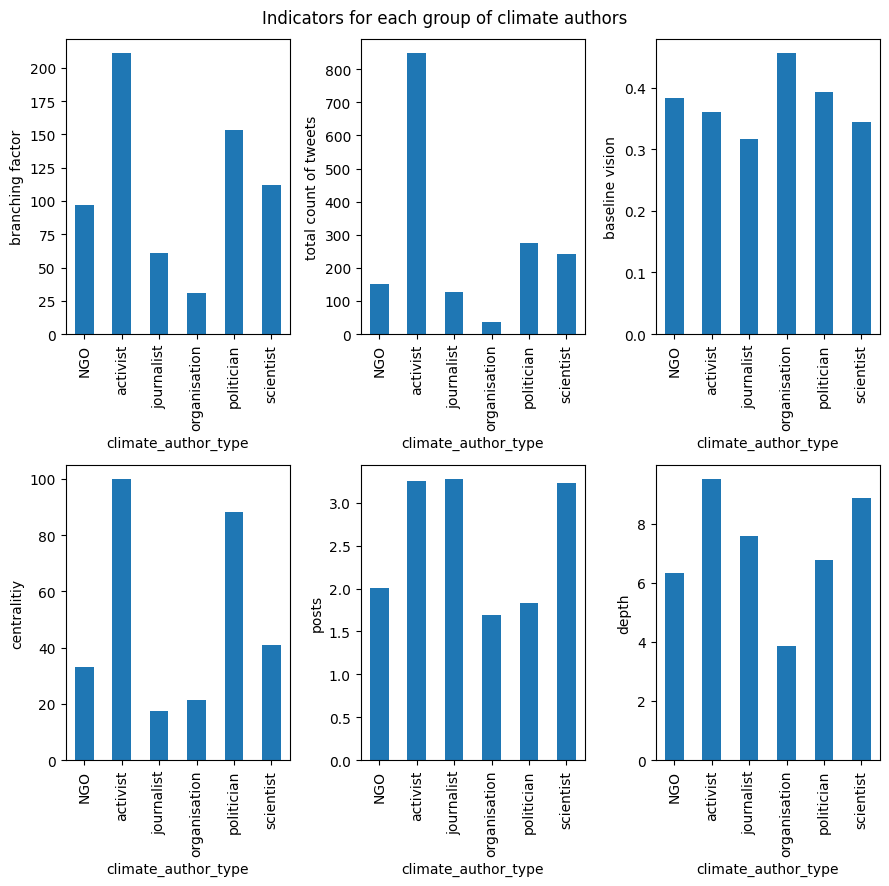

In [248]:
#plot mean of all conversations grouped by climate author type
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors")

ax1 = climate_analysis['branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = climate_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = climate_analysis['centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = climate_analysis['n_posts'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("posts");

ax5 = climate_analysis['baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = climate_analysis['depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [13]:
analysis_flattened.describe()

,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts
count,9142.000000,9.142000e+03,9142.0,7905.0,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,7905.000000,9142.000000
mean,383.670422,1.454809e+18,1.0,1.0,7.146869,108.979507,47.864585,0.376993,2.527514,109.926256,272.637607
std,237.701626,1.538300e+17,0.0,0.0,7.389131,351.667814,187.030324,0.162873,4.964834,351.682155,2880.595854
min,1.000000,3.629063e+17,1.0,1.0,2.000000,5.000000,0.068182,0.013889,1.000000,0.019231,6.000000
25%,317.000000,1.387702e+18,1.0,1.0,3.000000,9.000000,5.000000,0.250000,1.000000,10.000000,11.000000
50%,375.000000,1.503746e+18,1.0,1.0,5.000000,20.000000,9.205556,0.500000,1.000000,21.000000,25.000000
75%,401.000000,1.576478e+18,1.0,1.0,9.000000,62.000000,24.166667,0.500000,2.000000,63.000000,88.000000
max,1619.000000,1.622933e+18,1.0,1.0,113.000000,9285.000000,6652.180455,0.500000,113.000000,9286.000000,190875.000000


Following cells are to analysize wether dividing the variables by the total amount of tweets decreases the amount of outliers (it does).

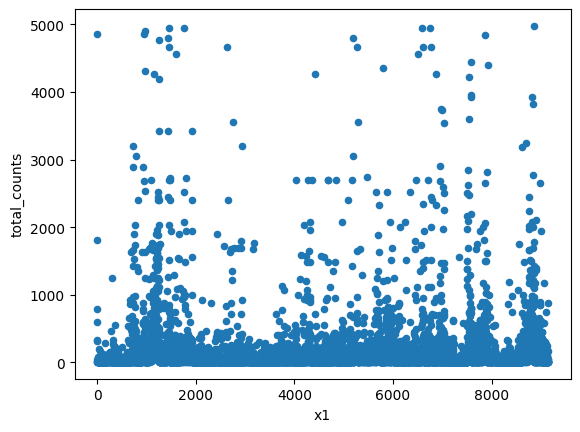

In [14]:
scatter_analysis = analysis_flattened.reset_index()
scatter_analysis = scatter_analysis[scatter_analysis.total_counts > 1]
scatter_analysis = scatter_analysis.drop(scatter_analysis[scatter_analysis['total_counts']>5000].index)
scatter_analysis['x1'] = scatter_analysis.index
scatter_analysis = scatter_analysis.sort_values('total_counts', ascending=True)
scatter_analysis
scatter_analysis.plot.scatter(x='x1', y="total_counts");

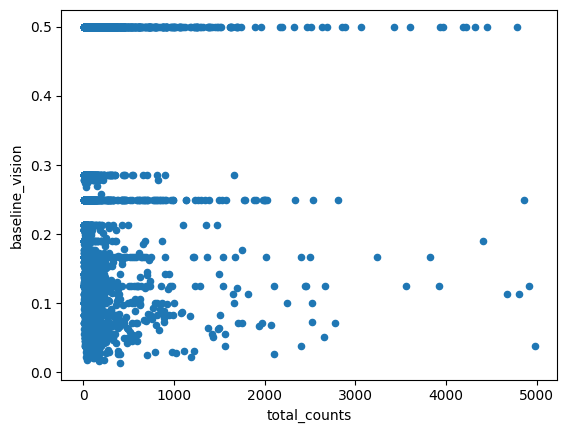

In [15]:
std = scatter_analysis['baseline_vision']
scatter_analysis.plot.scatter(x='total_counts', y= 'baseline_vision');

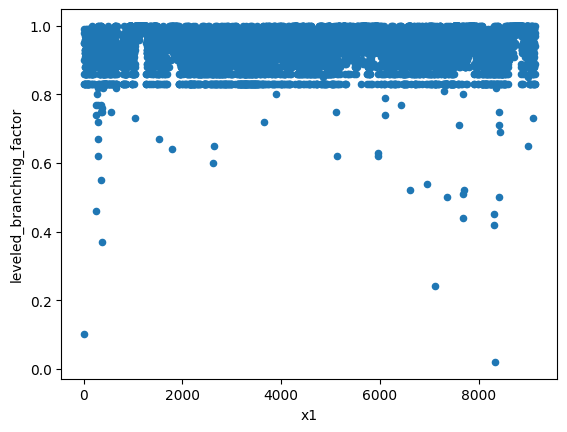

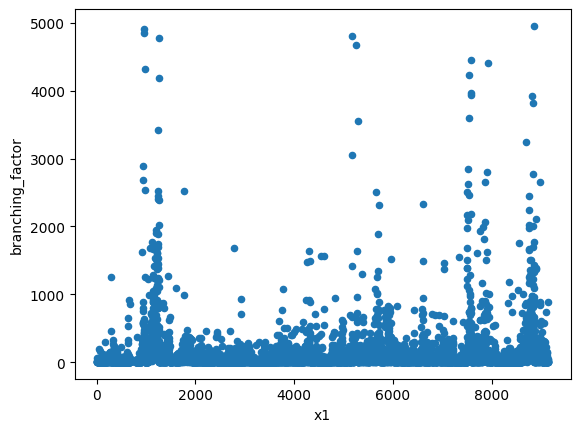

In [16]:
scatter_analysis['leveled_branching_factor']= (scatter_analysis["branching_factor"]/scatter_analysis["total_counts"]).round(2)
scatter_analysis.plot.scatter(x='x1', y="leveled_branching_factor")
scatter_analysis.plot.scatter(x='x1', y="branching_factor");

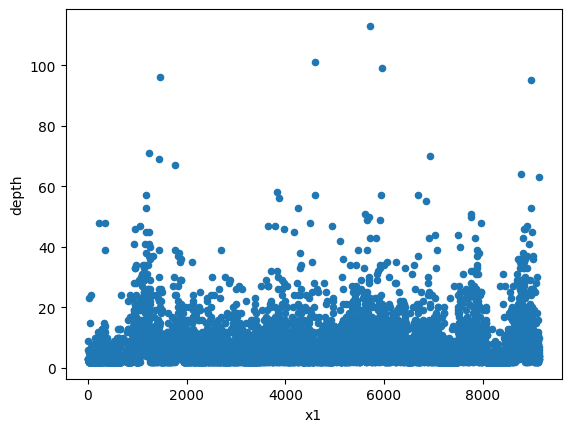

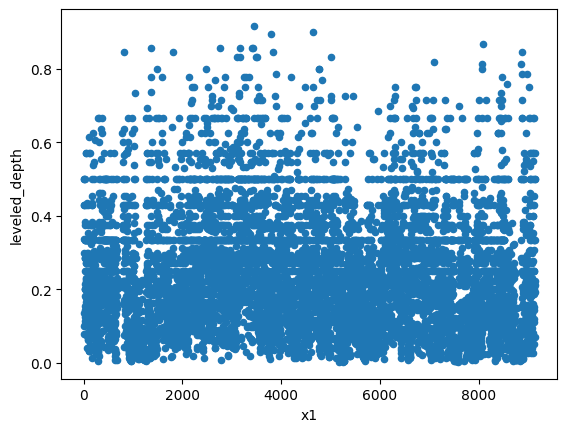

In [17]:
scatter_analysis.plot.scatter(x='x1', y="depth")
scatter_analysis['leveled_depth']= (scatter_analysis["depth"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_depth");

In [18]:
scatter_analysis

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth
4560,4560,375,721739546610806789,sven_giegold,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,4560,0.83,0.333333
2848,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,3.0,5.0,3.500000,0.500000,1.0,6.0,6,2848,0.83,0.500000
8206,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,8206,0.83,0.333333
4706,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,2.0,5.0,5.000000,0.500000,1.0,6.0,6,4706,0.83,0.333333
4707,4707,377,1402577374131195908,micha_bloss,politician,1.0,1.0,3.0,5.0,4.000000,0.500000,1.0,6.0,6,4707,0.83,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6595,6595,392,1596441230644477954,sascha_m_k,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6595,NaN,NaN
1449,1449,305,1596441230644477954,Perowinger94,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1449,NaN,NaN
1769,1769,310,1596441230644477954,NurderK,activist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,1769,NaN,NaN
6756,6756,396,1596441230644477954,ConstZerger,scientist,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4941,6756,NaN,NaN


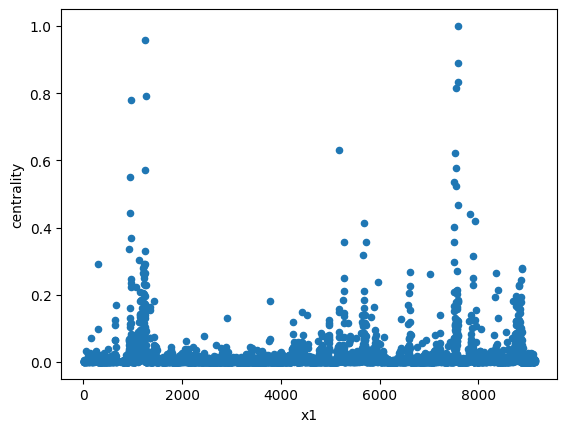

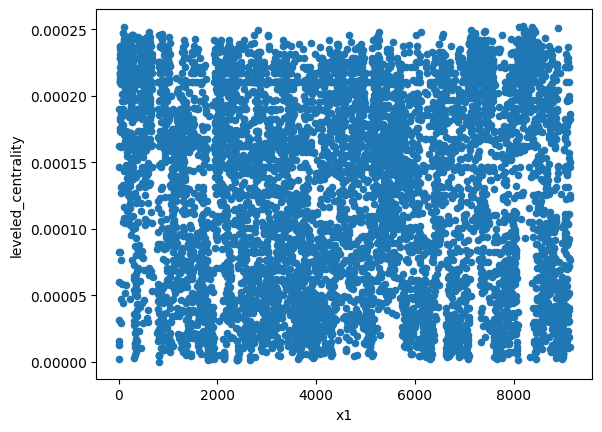

In [249]:
scatter_analysis.plot.scatter(x='x1', y="centrality")
scatter_analysis['leveled_centrality']= (scatter_analysis["centrality"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_centrality");

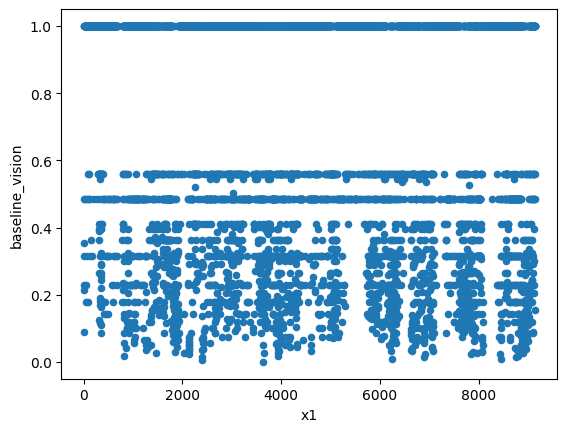

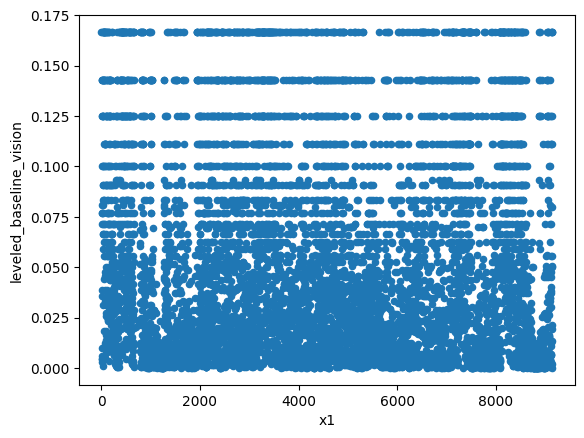

In [250]:
scatter_analysis.plot.scatter(x='x1', y="baseline_vision")
scatter_analysis['leveled_baseline_vision']= (scatter_analysis["baseline_vision"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="leveled_baseline_vision");

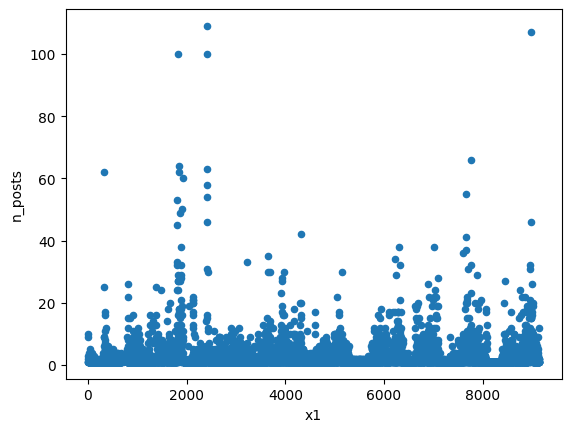

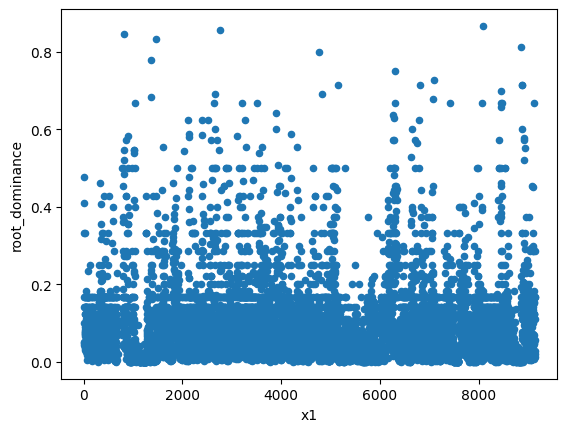

In [251]:
#n_posts divided by total counts of posts is the same as the root dominance from the delab_tree library
scatter_analysis.plot.scatter(x='x1', y="n_posts")
scatter_analysis['root_dominance']= (scatter_analysis["n_posts"]/scatter_analysis["total_counts"])
scatter_analysis.plot.scatter(x='x1', y="root_dominance");

In [252]:
#group the variables divided by the total count of tweets by climate author type
leveled_analysis = scatter_analysis.groupby('climate_author_type').mean()
leveled_analysis

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
climate_author_type,,,,,,,,,,,,,,,,,
NGO,3670.912844,320.630734,1.445580e+18,1.0,1.0,0.039042,0.018558,0.008455,0.759847,2.004014,0.109374,97.850917,3670.912844,0.924932,0.289118,0.000135,0.061250
activist,1936.874178,311.180282,1.430936e+18,1.0,1.0,0.067098,0.039953,0.023990,0.714261,3.262911,0.082979,203.826291,1936.874178,0.954479,0.204700,0.000121,0.033117
journalist,4078.354415,388.541766,1.452353e+18,1.0,1.0,0.050195,0.011360,0.004450,0.622446,3.278043,0.124588,62.328162,4078.354415,0.938520,0.295370,0.000101,0.042349
organisation,5191.180630,323.036895,1.450889e+18,1.0,1.0,0.016779,0.005302,0.005412,0.909742,1.695619,0.098001,32.615680,5191.180630,0.912101,0.257143,0.000182,0.075584
politician,5238.347948,401.172575,1.429393e+18,1.0,1.0,0.042532,0.028969,0.022561,0.779775,1.824627,0.090666,149.319963,5238.347948,0.940127,0.242701,0.000144,0.046752
scientist,6379.550478,503.173220,1.484439e+18,1.0,1.0,0.061670,0.021057,0.010463,0.678255,3.172689,0.093251,110.656748,6379.550478,0.947874,0.241620,0.000111,0.035540


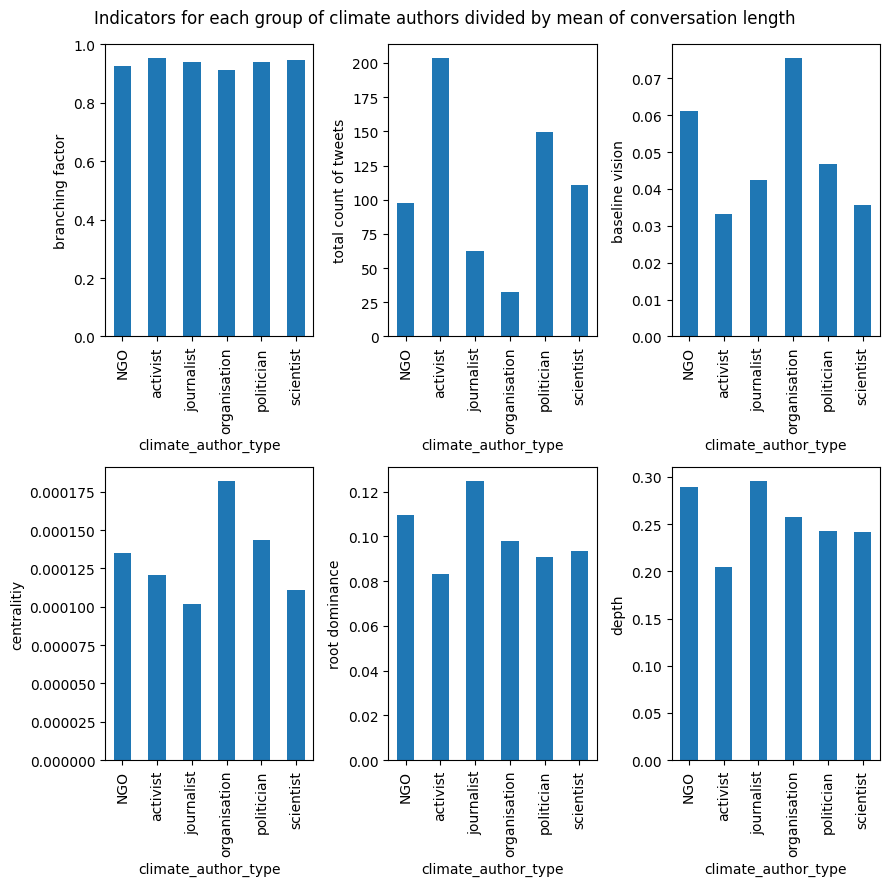

In [253]:
#plot the new dataframe in order to get results less sensitive to outliers
fig, axes = plt.subplots(nrows=2, ncols=3, tight_layout=True, figsize=(9,9))
fig.suptitle("Indicators for each group of climate authors divided by mean of conversation length")

ax1 = leveled_analysis['leveled_branching_factor'].plot.bar(ax=axes[0,0])
ax1.set_ylabel("branching factor")

ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[0,1])
ax2.set_ylabel("total count of tweets")

ax3 = leveled_analysis['leveled_centrality'].plot.bar(ax=axes[1,0])
ax3.set_ylabel("centralitiy")

ax4 = leveled_analysis['root_dominance'].plot.bar(ax=axes[1,1])
ax4.set_ylabel("root dominance");

ax5 = leveled_analysis['leveled_baseline_vision'].plot.bar(ax=axes[0,2])
ax5.set_ylabel("baseline vision")

ax6 = leveled_analysis['leveled_depth'].plot.bar(ax=axes[1,2])
ax6.set_ylabel("depth");

In [254]:
from sklearn.preprocessing import MinMaxScaler

In [255]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(leveled_analysis)
normalized_df = pd.DataFrame(normalized_data, columns=leveled_analysis.columns)
author_types = ['NGO', 'activists', 'journalists', 'organisations', 'politicians', 'scientists'] 
normalized_df['author_type'] = author_types
normalized_df = normalized_df.set_index('author_type')
normalized_df

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
author_type,,,,,,,,,,,,,,,,,
NGO,0.390314,0.049223,0.294058,0.0,0.0,0.442452,0.382560,0.204950,0.478258,0.194888,0.634367,0.381023,0.390314,0.302783,0.931045,0.421695,0.662466
activists,0.000000,0.000000,0.028042,0.0,0.0,1.000000,1.000000,1.000000,0.319584,0.990437,0.000000,1.000000,0.000000,1.000000,0.000000,0.241811,0.000000
journalists,0.482025,0.402939,0.417114,0.0,0.0,0.664077,0.174822,0.000000,0.000000,1.000000,1.000000,0.173543,0.482025,0.623408,1.000000,0.000000,0.217377
organisations,0.732510,0.061755,0.390515,0.0,0.0,0.000000,0.000000,0.049208,1.000000,0.000000,0.361031,0.000000,0.732510,0.000000,0.578389,1.000000,1.000000
politicians,0.743127,0.468727,0.000000,0.0,0.0,0.511804,0.683006,0.926887,0.547621,0.081526,0.184750,0.681642,0.743127,0.661337,0.419105,0.525240,0.321061
scientists,1.000000,1.000000,1.000000,0.0,0.0,0.892129,0.454674,0.307723,0.194255,0.933422,0.246862,0.455819,1.000000,0.844126,0.407183,0.114986,0.057044


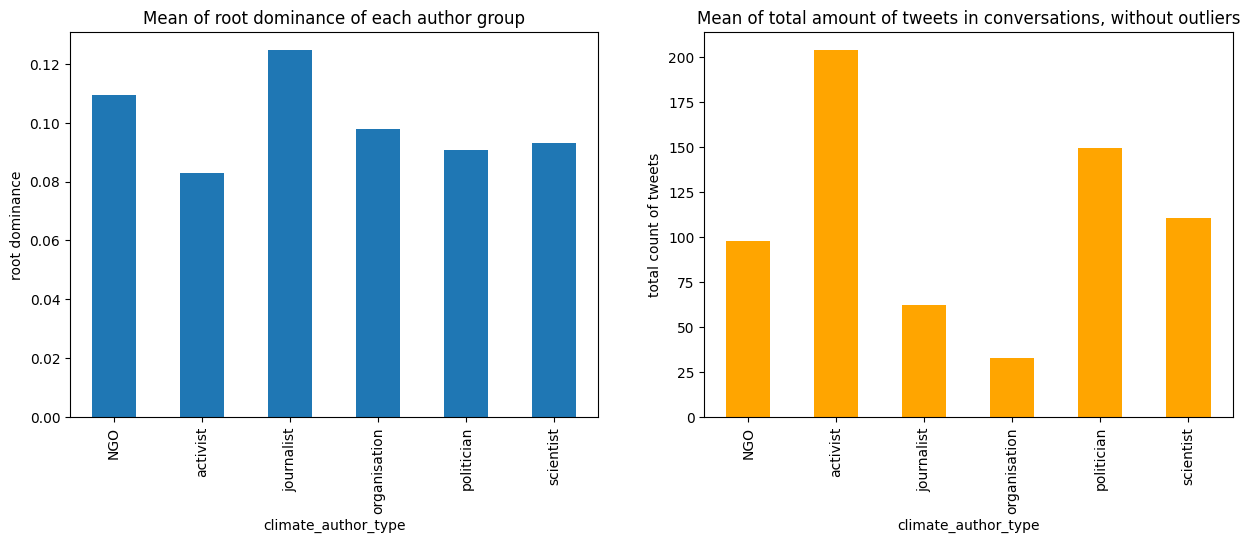

In [256]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1 = leveled_analysis['root_dominance'].plot.bar(ax=axes[0])
ax1.set_ylabel("root dominance")
ax1.set_title("Mean of root dominance of each author group")
ax2 = leveled_analysis['total_counts'].plot.bar(ax=axes[1], color='orange')
ax2.set_ylabel("total count of tweets")
ax2.set_title("Mean of total amount of tweets in conversations, without outliers");

In [257]:
scatter_analysis = scatter_analysis.dropna()
scatter_analysis

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
4560,4560,375,721739546610806789,sven_giegold,politician,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.166667,6,4560,0.826531,0.361547,0.000210,0.166667
2848,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,0.009009,0.000000,0.000878,1.000000,1.0,0.166667,6,2848,0.826531,0.543962,0.000146,0.166667
8206,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.166667,6,8206,0.826531,0.361547,0.000210,0.166667
4706,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.166667,6,4706,0.826531,0.361547,0.000210,0.166667
4707,4707,377,1402577374131195908,micha_bloss,politician,1.0,1.0,0.009009,0.000000,0.001006,1.000000,1.0,0.166667,6,4707,0.826531,0.543962,0.000168,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,1254,300,1608777813309665282,Luisamneubauer,activist,1.0,1.0,0.171171,0.964423,0.957584,1.000000,1.0,0.000209,4777,1254,1.000000,0.001528,0.000200,0.000209
5178,5178,380,1595324700053458949,Ricarda_Lang,politician,1.0,1.0,0.306306,0.969476,0.156329,0.206071,5.0,0.001041,4802,5178,1.000000,0.004922,0.000033,0.000043
958,958,296,1549352210277990400,GretaThunberg,activist,1.0,1.0,0.396396,0.980190,0.369215,0.485714,2.0,0.000412,4855,958,1.000000,0.007087,0.000076,0.000100
965,965,296,1585549056880820225,GretaThunberg,activist,1.0,1.0,0.279279,0.991106,0.222674,0.228571,4.0,0.000815,4909,965,1.000000,0.004074,0.000045,0.000047


In [329]:
scaler = MinMaxScaler()

to_plot_df = scatter_analysis
columns = ['depth', 'branching_factor', 'baseline_vision', 'centrality','leveled_branching_factor', 'leveled_depth', 'leveled_centrality', 'leveled_baseline_vision', 'root_dominance', 'total_counts']
to_plot_df[columns] = scaler.fit_transform(to_plot_df[columns])

to_plot_df

,index,author_id,conversation_id,screen_name,climate_author_type,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
4560,4560,375,721739546610806789,sven_giegold,politician,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.192113,0.000000,4560,0.826531,0.361547,0.833236,1.000000
2848,2848,344,1124663673933451266,fff_hamburg,NGO,1.0,1.0,0.009009,0.000000,0.000878,1.000000,1.0,0.192113,0.000000,2848,0.826531,0.543962,0.579809,1.000000
8206,8206,434,1548940857084182530,UNEP,organisation,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.192113,0.000000,8206,0.826531,0.361547,0.833236,1.000000
4706,4706,377,1401869295731150850,micha_bloss,politician,1.0,1.0,0.000000,0.000000,0.001262,1.000000,1.0,0.192113,0.000000,4706,0.826531,0.361547,0.833236,1.000000
4707,4707,377,1402577374131195908,micha_bloss,politician,1.0,1.0,0.009009,0.000000,0.001006,1.000000,1.0,0.192113,0.000000,4707,0.826531,0.543962,0.664285,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,1254,300,1608777813309665282,Luisamneubauer,activist,1.0,1.0,0.171171,0.964423,0.957584,1.000000,1.0,0.000000,0.959574,1254,1.000000,0.001528,0.793827,0.001256
5178,5178,380,1595324700053458949,Ricarda_Lang,politician,1.0,1.0,0.306306,0.969476,0.156329,0.206071,5.0,0.000960,0.964602,5178,1.000000,0.004922,0.128921,0.000257
958,958,296,1549352210277990400,GretaThunberg,activist,1.0,1.0,0.396396,0.980190,0.369215,0.485714,2.0,0.000234,0.975261,958,1.000000,0.007087,0.301158,0.000600
965,965,296,1585549056880820225,GretaThunberg,activist,1.0,1.0,0.279279,0.991106,0.222674,0.228571,4.0,0.000699,0.986122,965,1.000000,0.004074,0.179631,0.000279


In [330]:
to_plot_df = to_plot_df.groupby(['climate_author_type']).mean()
to_plot_df

,index,author_id,conversation_id,is_climate_author,is_root_author,depth,branching_factor,centrality,baseline_vision,n_posts,root_dominance,total_counts,x1,leveled_branching_factor,leveled_depth,leveled_centrality,leveled_baseline_vision
climate_author_type,,,,,,,,,,,,,,,,,
NGO,3670.912844,320.630734,1.445580e+18,1.0,1.0,0.039042,0.018558,0.008455,0.759847,2.004014,0.125990,0.018474,3670.912844,0.924932,0.289118,0.535851,0.367501
activist,1936.874178,311.180282,1.430936e+18,1.0,1.0,0.067098,0.039953,0.023990,0.714261,3.262911,0.095526,0.039788,1936.874178,0.954479,0.204700,0.478676,0.198703
journalist,4078.354415,388.541766,1.452353e+18,1.0,1.0,0.050195,0.011360,0.004450,0.622446,3.278043,0.143548,0.011329,4078.354415,0.938520,0.295370,0.401817,0.254091
organisation,5191.180630,323.036895,1.450889e+18,1.0,1.0,0.016779,0.005302,0.005412,0.909742,1.695619,0.112864,0.005353,5191.180630,0.912101,0.257143,0.719664,0.453505
politician,5238.347948,401.172575,1.429393e+18,1.0,1.0,0.042532,0.028969,0.022561,0.779775,1.824627,0.104398,0.028825,5238.347948,0.940127,0.242701,0.568763,0.280510
scientist,6379.550478,503.173220,1.484439e+18,1.0,1.0,0.061670,0.021057,0.010463,0.678255,3.172689,0.107381,0.021049,6379.550478,0.947874,0.241620,0.438365,0.213238


/tmp/ipykernel_6679/1785985154.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=15)


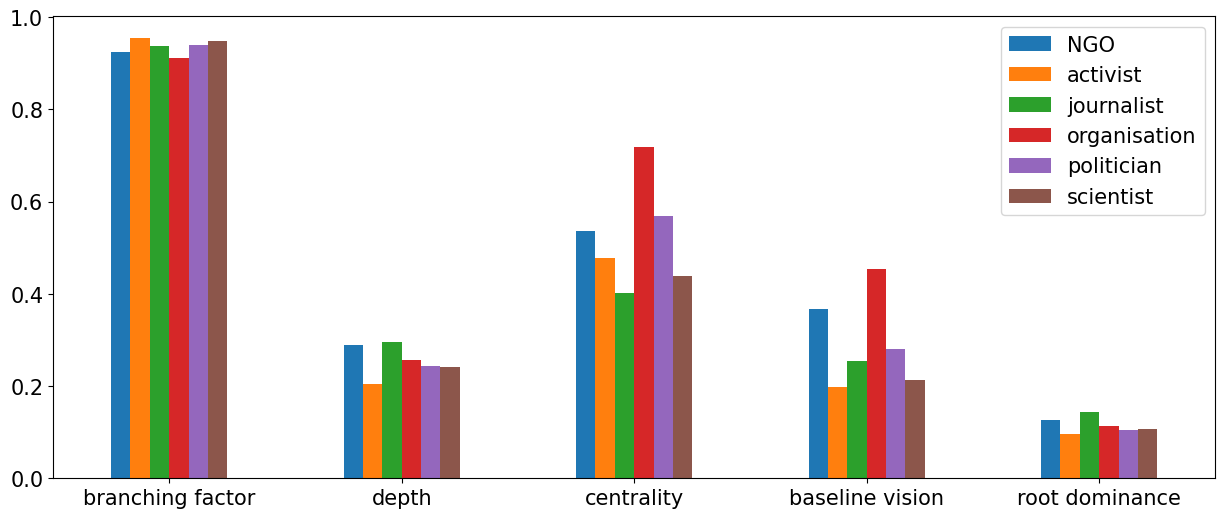

In [331]:
to_plot_df = to_plot_df.transpose()
rows = ['leveled_branching_factor', 'leveled_depth', 'leveled_centrality', 'leveled_baseline_vision', 'root_dominance']
xticks = ['branching factor', 'depth', 'centrality', 'baseline vision', 'root dominance']
plot = to_plot_df.loc[rows].plot.bar(figsize=(15,6))
plot.set_xticklabels(xticks, rotation='horizontal', fontsize=15)
plot.set_yticklabels([0.0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plot.legend(fontsize=15)

fig = plot.get_figure()
fig.savefig('min_max_normalized_var.pdf')

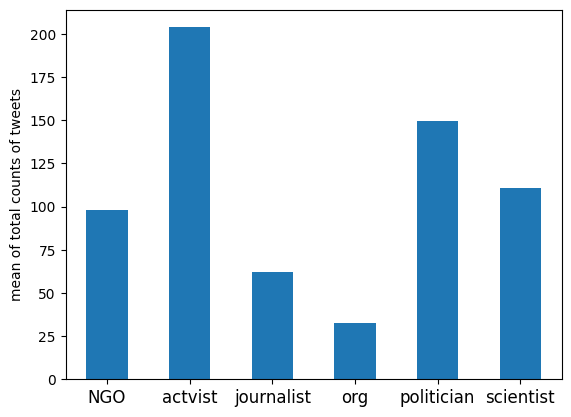

In [327]:
plot = leveled_analysis['total_counts'].plot.bar()
plot.set_xticklabels(['NGO', 'actvist', 'journalist', 'org', 'politician', 'scientist'], rotation='horizontal', fontsize=12)
plot.set_ylabel('mean of total counts of tweets')
plot.set_xlabel('')
fig = plot.get_figure()
fig.savefig('total_counts_plot.pdf')

In [234]:
rows = ['leveled_branching_factor', 'leveled_depth', 'leveled_centrality', 'leveled_baseline_vision']

to_plot_df

climate_author_type,NGO,activist,journalist,organisation,politician,scientist
index,3.670913e+03,1.936874e+03,4.078354e+03,5.191181e+03,5.238348e+03,6.379550e+03
author_id,3.206307e+02,3.111803e+02,3.885418e+02,3.230369e+02,4.011726e+02,5.031732e+02
conversation_id,1.445580e+18,1.430936e+18,1.452353e+18,1.450889e+18,1.429393e+18,1.484439e+18
is_climate_author,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
is_root_author,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
depth,3.904248e-02,6.709808e-02,5.019459e-02,1.677850e-02,4.253227e-02,6.167007e-02
branching_factor,1.855830e-02,3.995308e-02,1.136003e-02,5.302323e-03,2.896901e-02,2.105711e-02
centrality,8.455042e-03,2.398996e-02,4.450419e-03,5.411926e-03,2.256136e-02,1.046318e-02
baseline_vision,7.598475e-01,7.142614e-01,6.224463e-01,9.097416e-01,7.797751e-01,6.782548e-01
n_posts,2.004014e+00,3.262911e+00,3.278043e+00,1.695619e+00,1.824627e+00,3.172689e+00
